Text(0, 0.5, 'MJD')

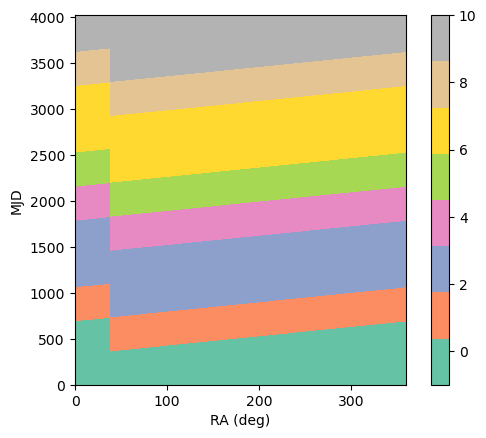

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rubin_scheduler.utils import survey_start_mjd, calc_season

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.scheduler.utils import scheduled_observation
from rubin_scheduler.utils import  ddf_locations
from rubin_scheduler.scheduler.surveys import generate_ddf_scheduled_obs

ra = np.arange(0, 360, 1)
mjds = np.arange(survey_start_mjd(), survey_start_mjd()+11*365.25, 1)
seasons = calc_season(ra, mjds)
seasons = np.swapaxes(seasons, 0, 1)
seasons = np.floor(seasons)

plt.imshow(seasons, aspect=.1, origin='lower', cmap='Set2')
plt.colorbar()
plt.xlabel("RA (deg)")
plt.ylabel("MJD")

In [74]:
def ddf_slopes_new(ddf_name, raw_obs, night_season, min_season=60 / 365.25):
    """
    Let's make custom slopes for each DDF

    Parameters
    ----------
    ddf_name : `str`
       The DDF name to use
    raw_obs : `np.array`, (N,)
        An array with values of 1 or zero. One element per night, value of
        1 indicates the night is during an active observing season.
    night_season : `np.array`, (N,)
        An array of floats with the fractional season value.
        Season values range from 0-1 for the first season;
        0.5 would be the "peak" of seasonal visiblity.
        These should ONLY be the night the field should be 'active'
        (take out the season ends first).
    min_season : `float`, optional
        Minimal season length that is useful.
        In units of "season" (fractions of a year).
    """

    # OK, so 258 sequences is ~1% of the survey
    # so a 25.8 sequences is a 0.1% season
    # COSMOS is going to be 0.7% for 3 years, then 0.175 for the rest.

    ss = 30  # standard season, was 45 .. note this may be affected by season length

    int_season = np.floor(night_season)

    n_season = night_season[np.where(raw_obs)]
    r_season = int_season[np.where(raw_obs)]
    season_list = np.unique(r_season)

    # Calculate season length for each season
    # In general this should be the same each season except for first and last
    season_length = np.zeros(len(season_list), float)
    for i, season in enumerate(season_list):
        match = np.where(r_season == season)
        season_length[i] = n_season[match].max() - n_season[match].min()

    # Determine goal number of sequences in each season.
    season_vals = np.ones(len(season_list), float) * ss
    # Throw out seasons which are too short
    too_short = np.where(season_length < min_season)
    season_vals[too_short] = 0
    # Adjust other seasons, relative to the max season length.
    season_vals = season_vals * season_length / np.max(season_length)

    # Add extra adjustment for COSMOS to boost visits in seasons 0-3 
    # Note this means boost in first incomplete season too
    if ddf_name == "COSMOS":
        season_vals[0:3] = season_vals[0:3] * 5
        season_vals[3] = season_vals[3] * 2

    if ddf_name == "EDFS_b":
        # EDFS_b ddf visits are allocated some other way
        season_vals = season_vals * 0

    # Round the season_vals so that we're looking for integer sequences
    season_vals = np.round(season_vals)

    #print(list(zip(season_vals, season_length)))
          
    # assign cumulative values
    cumulative_desired = np.zeros(raw_obs.size, dtype=float)
    for i, season in enumerate(season_list):
        in_season = np.where(int_season == season)
        cumulative = np.cumsum(raw_obs[in_season])
        if cumulative.max() > 0:
            cumulative = cumulative / cumulative.max() * season_vals[i]
            cumulative_desired[in_season] = cumulative + np.max(cumulative_desired)

    return cumulative_desired

In [67]:
def ddf_slopes_old(ddf_name, raw_obs, night_season):
    """
    Let's make custom slopes for each DDF

    Parameters
    ----------
    ddf_name : str
       The DDF name to use
    raw_obs : np.array
        An array with values of 1 or zero. One element per night, value of
        1 indicates the night is during an active observing season.
    night_season : np.array
        An array of floats with the fractional season value
        (e.g., 0.5 would be half way through the first season)
    """

    # OK, so 258 sequences is ~1% of the survey
    # so a 25.8 sequences is a 0.1% season
    # COSMOS is going to be 0.7% for 3 years, then 0.175 for the rest.

    ss = 30  # standard season, was 45

    if (ddf_name == "ELAISS1") | (ddf_name == "XMM_LSS") | (ddf_name == "ECDFS"):
        # Dict with keys for each season and values of the number of
        # sequences to attempt.
        season_vals = {
            0: 10,
            1: ss,
            2: ss,
            3: ss,
            4: ss,
            5: ss,
            6: ss,
            7: ss,
            8: ss,
            9: ss,
            10: 10,
        }

        round_season = np.floor(night_season)

        cumulative_desired = np.zeros(raw_obs.size, dtype=float)
        for season in np.unique(round_season):
            in_season = np.where(round_season == season)
            cumulative = np.cumsum(raw_obs[in_season])
            if cumulative.max() > 0:
                cumulative = cumulative / cumulative.max() * season_vals[season]
                cumulative_desired[in_season] = cumulative + np.max(cumulative_desired)

    if ddf_name == "EDFS_a":
        season_vals = {
            0: 10,
            1: ss,
            2: ss,
            3: ss,
            4: ss,
            5: ss,
            6: ss,
            7: ss,
            8: ss,
            9: ss,
            10: 10,
        }

        round_season = np.floor(night_season)

        cumulative_desired = np.zeros(raw_obs.size, dtype=float)
        for season in np.unique(round_season):
            in_season = np.where(round_season == season)
            cumulative = np.cumsum(raw_obs[in_season])
            if cumulative.max() > 0:
                cumulative = cumulative / cumulative.max() * season_vals[season]
                cumulative_desired[in_season] = cumulative + np.max(cumulative_desired)

    if ddf_name == "COSMOS":
        # looks like COSMOS has no in-season time for 10 at the
        # current start mjd.
        season_vals = {
            0: 10,
            1: ss * 5,
            2: ss * 5,
            3: ss * 2,
            4: ss,
            5: ss,
            6: ss,
            7: ss,
            8: ss,
            9: ss,
            10: 10,
        }

        round_season = np.floor(night_season)

        cumulative_desired = np.zeros(raw_obs.size, dtype=float)
        for season in np.unique(round_season):
            in_season = np.where(round_season == season)[0]
            cumulative = np.cumsum(raw_obs[in_season])
            if cumulative.max() > 0:
                cumulative = cumulative / cumulative.max() * season_vals[season]
                cumulative_desired[in_season] = cumulative + np.max(cumulative_desired)

    return cumulative_desired

In [57]:
def optimize_ddf_times(
    ddf_name,
    ddf_RA,
    ddf_grid,
    sun_limit=-18,
    sequence_time=60.0,
    airmass_limit=2.5,
    sky_limit=None,
    g_depth_limit=23.5,
    season_unobs_frac=0.1,
    old=False
):
    """

    Parameters
    ----------
    ddf : `str`
        The name of the DDF
    ddf_grid : `np.array`
        An array with info for the DDFs. Generated by the
        rubin_scheduler.scheduler/surveys/generate_ddf_grid.py` script
    season_unobs_frac : `float`
        7.2 month observing season if season_unobs_frac = 0.2
        (shaves 20% off each end of the full year)
    sequence_time : `float`
        How long a sequence is expected to be (minutes). Used to make
        sure things are not scheduled too close to twilight.
    """
    sun_limit = np.radians(sun_limit)
    sequence_time = sequence_time / 60.0 / 24.0  # to days

    # XXX-- double check that I got this right
    ack = ddf_grid["sun_alt"][0:-1] * ddf_grid["sun_alt"][1:]
    night = np.zeros(ddf_grid.size, dtype=int)
    night[np.where((ddf_grid["sun_alt"][1:] >= 0) & (ack < 0))] += 1
    night = np.cumsum(night)
    ngrid = ddf_grid["mjd"].size

    # set a sun, airmass, sky masks
    sun_mask = np.ones(ngrid, dtype=int)
    sun_mask[np.where(ddf_grid["sun_alt"] >= sun_limit)] = 0

    # expand sun mask backwards by the sequence time.
    n_back = np.ceil(sequence_time / (ddf_grid["mjd"][1] - ddf_grid["mjd"][0])).astype(int)
    shadow_indx = np.where(sun_mask == 0)[0] - n_back
    shadow_indx = shadow_indx[np.where(shadow_indx >= 0)]

    sun_mask[shadow_indx] = 0

    airmass_mask = np.ones(ngrid, dtype=int)
    airmass_mask[np.where(ddf_grid["%s_airmass" % ddf_name] >= airmass_limit)] = 0

    sky_mask = np.ones(ngrid, dtype=int)
    if sky_limit is not None:
        sky_mask[np.where(ddf_grid["%s_sky_g" % ddf_name] <= sky_limit)] = 0
        sky_mask[np.where(np.isnan(ddf_grid["%s_sky_g" % ddf_name]) == True)] = 0

    m5_mask = np.zeros(ngrid, dtype=bool)
    m5_mask[np.isfinite(ddf_grid["%s_m5_g" % ddf_name])] = 1

    if g_depth_limit is not None:
        m5_mask[np.where(ddf_grid["%s_m5_g" % ddf_name] < g_depth_limit)] = 0

    big_mask = sun_mask * airmass_mask * sky_mask * m5_mask

    potential_nights = np.unique(night[np.where(big_mask > 0)])

    # prevent a repeat sequence in a night
    unights, indx = np.unique(night, return_index=True)
    night_mjd = ddf_grid["mjd"][indx]
    # The season of each night
    night_season = calc_season(ddf_RA, night_mjd)

    # Mod by 1 to turn the season value in each night a simple 0-1 value
    season_mod = night_season % 1
    # Remove the tails of the seasons which are within "season_unobs_fract"
    # Note that the "season" does include times where the field wouldn't
    # really have been observable, due to being too close to the sun.
    # Small values of season_unobs_frac may not reduce the usable season.
    out_season = np.where((season_mod < season_unobs_frac) | (season_mod > (1.0 - season_unobs_frac)))

    raw_obs = np.ones(unights.size)
    raw_obs[out_season] = 0

    if old:
        night_season = night_season - np.floor(night_season).min()
        cumulative_desired = ddf_slopes_old(ddf_name, raw_obs, night_season)
    else:
        cumulative_desired = ddf_slopes_new(ddf_name, raw_obs, night_season)

    night_mask = unights * 0
    night_mask[potential_nights] = 1

    unight_sched = match_cumulative(cumulative_desired, mask=night_mask)
    cumulative_sched = np.cumsum(unight_sched)

    nights_to_use = unights[np.where(unight_sched == 1)]

    # For each night, find the best time in the night.
    # XXX--probably need to expand this part to resolve the times when
    # multiple things get scheduled
    mjds = []
    for night_check in nights_to_use:
        in_night = np.where((night == night_check) & (np.isfinite(ddf_grid["%s_m5_g" % ddf_name])))[0]
        m5s = ddf_grid["%s_m5_g" % ddf_name][in_night]
        # we could intorpolate this to get even better than 15 min
        # resolution on when to observe
        max_indx = np.where(m5s == m5s.max())[0].min()
        mjds.append(ddf_grid["mjd"][in_night[max_indx]])

    return mjds, night_mjd, cumulative_desired, cumulative_sched

def match_cumulative(cumulative_desired, mask=None, no_duplicate=True):
    """Generate a schedule that tries to match the desired cumulative
    distribution given a mask

    Parameters
    ----------
    cumulative_desired : `np.array`, float
        An array with the cumulative number of desired observations.
        Elements  are assumed to be evenly spaced.
    mask : `np.array`, bool or int (None)
        Set to zero for indices that cannot be scheduled
    no_duplicate : `bool` (True)
        If True, only 1 event can be scheduled per element

    Returns
    -------
    schedule : `np.array`
        The resulting schedule, with values marking number of events
        in that cell.
    """

    rounded_desired = np.round(cumulative_desired)
    sched = cumulative_desired * 0
    if mask is None:
        mask = np.ones(sched.size)

    valid = np.where(mask > 0)[0].tolist()
    x = np.arange(sched.size)

    drd = np.diff(rounded_desired)
    step_points = np.where(drd > 0)[0] + 1

    # would be nice to eliminate this loop, but it's not too bad.
    # can't just use searchsorted on the whole array, because then there
    # can be duplicate values, and array[[n,n]] = 1 means that extra
    # match gets lost.
    for indx in step_points:
        left = np.searchsorted(x[valid], indx)
        right = np.searchsorted(x[valid], indx, side="right")
        d1 = indx - left
        d2 = right - indx
        if d1 < d2:
            sched_at = left
        else:
            sched_at = right

        # If we are off the end
        if sched_at >= len(valid):
            sched_at -= 1

        sched[valid[sched_at]] += 1
        if no_duplicate:
            valid.pop(sched_at)

    return sched

In [65]:
data_file = os.path.join(get_data_dir(), "scheduler", "ddf_grid.npz")
mjd_start = survey_start_mjd()
ddfs = ddf_locations()
ddf_data = np.load(data_file)
ddf_grid = ddf_data["ddf_grid"].copy()

mjd_max = mjd_start + 10. * 365.25

in_range = np.where((ddf_grid["mjd"] >= mjd_start) & (ddf_grid["mjd"] <= mjd_max))
ddf_grid = ddf_grid[in_range]

In [77]:
ddf_name = "XMM_LSS"
mjdso, night_mjdo, cumulative_desiredo, cumulative_schedo = optimize_ddf_times(
            ddf_name,
            ddfs[ddf_name][0],
            ddf_grid,
            season_unobs_frac=0.1,
            sequence_time=60,
            old = True
        )

mjds, night_mjd, cumulative_desired, cumulative_sched = optimize_ddf_times(
            ddf_name,
            ddfs[ddf_name][0],
            ddf_grid,
            season_unobs_frac=0.1,
            sequence_time=60,
            old = False
        )

In [78]:
#plt.plot(night_mjd, cumulative_sched)
#print(cumulative_sched[-1])

season_mjd = calc_season(ddfs[ddf_name][0], mjds)
season_mjdo = calc_season(ddfs[ddf_name][0], mjdso)
#plt.scatter(season_mjd, cumulative_sched)

print("season #mjd_new  #mjd_old")
total = 0
totalo = 0
for season in np.arange(-1, 11, 1):
    match = np.where(np.floor(season_mjd) == season)[0]
    total += len(match)
    matcho = np.where(np.floor(season_mjdo) == season)[0]
    totalo += len(matcho)
    print(season, len(match), len(matcho))
print(total, totalo)

season #mjd_new  #mjd_old
-1 27 9
0 31 29
1 30 30
2 29 29
3 31 31
4 30 30
5 30 30
6 30 30
7 29 29
8 33 33
9 0 0
10 0 0
300 280


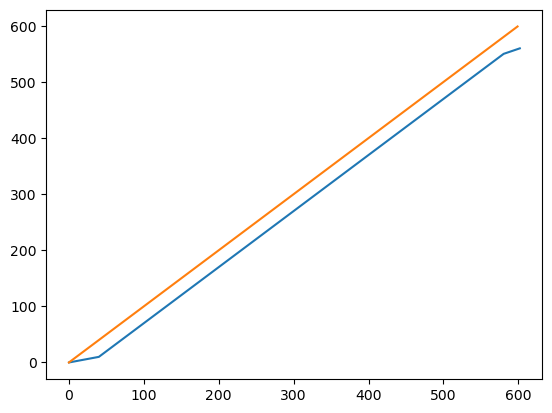

In [71]:
plt.plot(cumulative_desired, cumulative_desiredo)
x = np.arange(0, 600)
plt.plot(x, x)

602.0


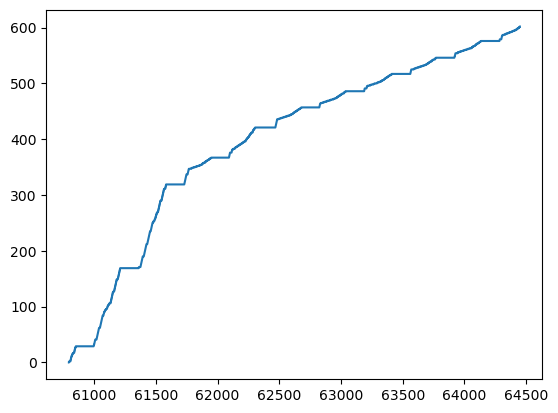

In [75]:
ddf_name = 'COSMOS'
mjds, night_mjd, cumulative_desired, cumulative_sched = optimize_ddf_times(
            ddf_name,
            ddfs[ddf_name][0],
            ddf_grid,
            season_unobs_frac=0.1,
            sequence_time=60,
        )
plt.plot(night_mjd, cumulative_sched)
print(cumulative_sched[-1])

In [42]:
first = np.where(night_season<0)
good_first_season = night_season[first][np.where(vals[2][first])]
(good_first_season.max() - good_first_season.min()) * 30

6.404004105285132

300.0


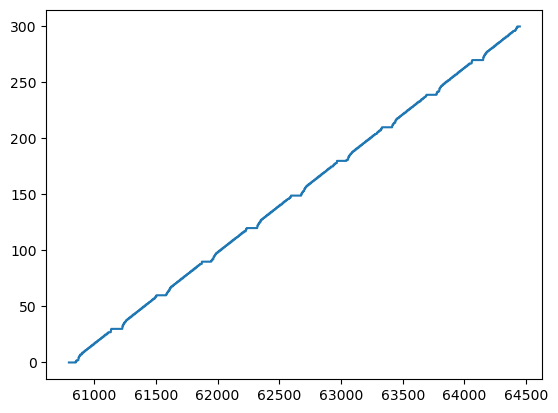

In [76]:
ddf_name = 'ECDFS'
mjds, night_mjd, cumulative_desired, cumulative_sched = optimize_ddf_times(
            ddf_name,
            ddfs[ddf_name][0],
            ddf_grid,
            season_unobs_frac=0.1,
            sequence_time=60,
        )
plt.plot(night_mjd, cumulative_sched)
print(cumulative_sched[-1])